In [1]:
#Import Libraries Here

#Base Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

#Ml Libraries
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error , r2_score

In [2]:

#Neural Network
from keras.models import Sequential
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization, LSTM
# from scikeras.wrappers import KerasClassifier


# Load and review the data

In [4]:
import glob

# List all CSV files in a directory
csv_files = glob.glob('vehicle/*.csv')

# Read each CSV file and concatenate them into one DataFrame
combined_vehicle_df = pd.concat((pd.read_csv(file) for file in csv_files), ignore_index=True)

# Save the combined DataFrame to a new CSV file
combined_vehicle_df.to_csv('combined_vehicle_output.csv', index=False)

# Data Exploration and Cleaning

In [6]:
combined_vehicle_copy=combined_vehicle_df.copy()

In [7]:
combined_vehicle_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79903 entries, 0 to 79902
Data columns (total 47 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Vehicle ID                             78585 non-null  object 
 1   Date                                   44897 non-null  object 
 2   Number of Trips                        7864 non-null   float64
 3   Total Distance                         72179 non-null  float64
 4   Idling Time                            51433 non-null  float64
 5   Driving Time                           60771 non-null  float64
 6   Total Run Time                         60254 non-null  float64
 7   Initial SOC                            40878 non-null  float64
 8   Final SOC                              41178 non-null  float64
 9   SOC Used                               65251 non-null  float64
 10  Total Energy Consumption               69594 non-null  float64
 11  Av

In [8]:
combined_vehicle_copy.head()

Vehicle ID             Date  Number of Trips  Total Distance  Idling Time  \
0      EV002  3/17/17 4:00 AM              NaN             0.3     0.862213   
1      EV002  3/20/17 4:00 AM              NaN            33.2     3.527856   
2      EV002  3/21/17 4:00 AM              NaN            56.0     2.453939   
3      EV002  3/28/17 4:00 AM              NaN            58.1     8.537252   
4      EV002  3/30/17 4:00 AM              NaN            50.3    12.206553   

   Driving Time  Total Run Time  Initial SOC  Final SOC  SOC Used  ...  \
0      0.067183        0.929396          NaN        NaN       3.0  ...   
1      2.366157        5.894013          NaN        NaN      41.0  ...   
2      3.966334        6.420273          NaN        NaN      49.0  ...   
3      2.841440       11.378692          NaN        NaN      43.0  ...   
4      2.334406       14.540959          NaN        NaN      41.0  ...   

   SOC Used for Driving SOC Used for Idling  Total Energy Charged  \
0                   NaN                 NaN                   NaN   
1                   NaN                 NaN                   NaN   
2                   NaN                 NaN                   NaN   
3                   NaN                 NaN                   NaN   
4                   NaN                 NaN                   NaN   

   Total Energy Driven Total Energy Idled  \
0                  NaN                NaN   
1                  NaN                NaN   
2                  NaN                NaN   
3                  NaN                NaN   
4                  NaN                NaN   

  Total Energy Regenerated from Driving  HV Accessories Energy  \
0                                   NaN                    NaN   
1                                   NaN                    NaN   
2                                   NaN                    NaN   
3                                   NaN                    NaN   
4                                   NaN                    NaN   

   LV Accessories Energy Electric Heater Energy  Regenerated Energy  
0                    NaN                    NaN                 NaN  
1                    NaN                    NaN                 NaN  
2                    NaN                    NaN                 NaN  
3                    NaN                    NaN                 NaN  
4                    NaN                    NaN                 NaN  

[5 rows x 47 columns]

In [9]:
# Replace 'NaN' strings with actual NaN values
combined_vehicle_copy = combined_vehicle_copy.replace('NaN', np.nan) # convert string NaN to nan
combined_vehicle_copy = combined_vehicle_copy.dropna(how='all') #  Removing Rows with All NaN Values
combined_vehicle_copy = combined_vehicle_copy.dropna(axis=1,how='all') #Removing Columns with all NaN Values

In [10]:
combined_vehicle_copy['Vehicle ID'].nunique()

222

In [11]:
#Remove EV for Vehicle ID and covert the reset to int for the Correlation table
combined_vehicle_copy['Vehicle ID']= combined_vehicle_copy['Vehicle ID'].str.replace('EV','',regex=False).astype(int)

In [12]:
combined_vehicle_copy['Date'].unique()

array(['3/17/17 4:00 AM', '3/20/17 4:00 AM', '3/21/17 4:00 AM', ...,
       '12/03/2023', '12/10/2023', '12/24/2023'], dtype=object)

In [13]:
# Step 1: Strip any extra whitespace
combined_vehicle_copy['Date'] = combined_vehicle_copy['Date'].str.strip()

# Step 2: Convert to datetime using errors='coerce' to handle mixed formats
combined_vehicle_copy['Date'] = pd.to_datetime(combined_vehicle_copy['Date'], errors='coerce')

# Step 3: Extract date and time in minutes
combined_vehicle_copy['Date_only'] = combined_vehicle_copy['Date'].dt.date
combined_vehicle_copy['Time_in_Minutes'] = combined_vehicle_copy['Date'].dt.hour * 60 + combined_vehicle_copy['Date'].dt.minute

# Optional: Drop the original Date column if not needed
combined_vehicle_copy = combined_vehicle_copy.drop(columns=['Date'])

C:\Users\marieo3\AppData\Local\Temp\ipykernel_35844\1204160688.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  combined_vehicle_copy['Date'] = pd.to_datetime(combined_vehicle_copy['Date'], errors='coerce')


In [14]:
# Check for duplice data based on the vehical ID and the start time stamp
# Group by 'Local Trip Start Time' and count unique 'Vehicle ID' entries
unique_vehicle_per_time = combined_vehicle_copy.groupby('Local Trip Start Time')['Vehicle ID'].nunique()

# Check if any 'Local Trip Start Time' has more than one unique 'Vehicle ID'
multiple_vehicle_ids = unique_vehicle_per_time[unique_vehicle_per_time > 1]

if multiple_vehicle_ids.empty:
    print("Each Local Trip Start Time has only one Vehicle ID.")
else:
    print("There are Local Trip Start Times with more than one Vehicle ID:")
    print(multiple_vehicle_ids)


There are Local Trip Start Times with more than one Vehicle ID:
Local Trip Start Time
01/02/2023 04:16:00    2
01/02/2023 16:23:00    2
01/03/2023 04:38:00    2
01/04/2022 06:07       2
01/04/2023 05:58:00    2
                      ..
9/6/18 2:42 PM         2
9/6/18 6:33 PM         2
9/7/18 10:14 AM        2
9/7/18 6:55 PM         2
9/9/18 5:23 PM         2
Name: Vehicle ID, Length: 756, dtype: int64


In [15]:
combined_vehicle_copy['Number of Trips'].unique()

array([nan, 46., 36., 12., 19., 35., 33., 52., 22., 48., 17., 21., 13.,
        5.,  8., 18., 31., 42., 29., 28., 40., 32., 54., 20., 43., 45.,
       50., 53., 44., 63., 39., 59., 47., 60., 49., 56., 25., 58., 62.,
       30., 73., 57., 26., 34., 24., 38., 55.,  7., 27.,  1., 41., 37.,
       11., 51., 16., 23., 10.,  9.,  4.,  6.,  2., 14., 15.,  3., 65.,
       77., 61., 64.])

In [16]:
combined_vehicle_copy = combined_vehicle_copy.dropna(subset=['Number of Trips'])

In [17]:
# Sort by Vehicle ID and Date_only to ensure order before counting
combined_vehicle_copy = combined_vehicle_copy.sort_values(by=['Vehicle ID', 'Date_only'])

# Group by Vehicle ID and then use cumcount() + 1 to populate the Number of Trips column
combined_vehicle_copy['Number of Trips'] = combined_vehicle_copy.groupby('Vehicle ID').cumcount() + 1

In [18]:
combined_vehicle_copy['Number of Trips'].unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [19]:
# Replace 'NaN' strings with actual NaN values
combined_vehicle_copy = combined_vehicle_copy.replace('NaN', np.nan) # convert string NaN to nan
combined_vehicle_copy = combined_vehicle_copy.dropna(how='all') #  Removing Rows with All NaN Values
combined_vehicle_copy = combined_vehicle_copy.dropna(axis=1,how='all') #Removing Columns with all NaN Values

In [20]:
dropped_objects_df=combined_vehicle_copy.drop([ 'Date_only' ],axis=1)


# Visualize the Data

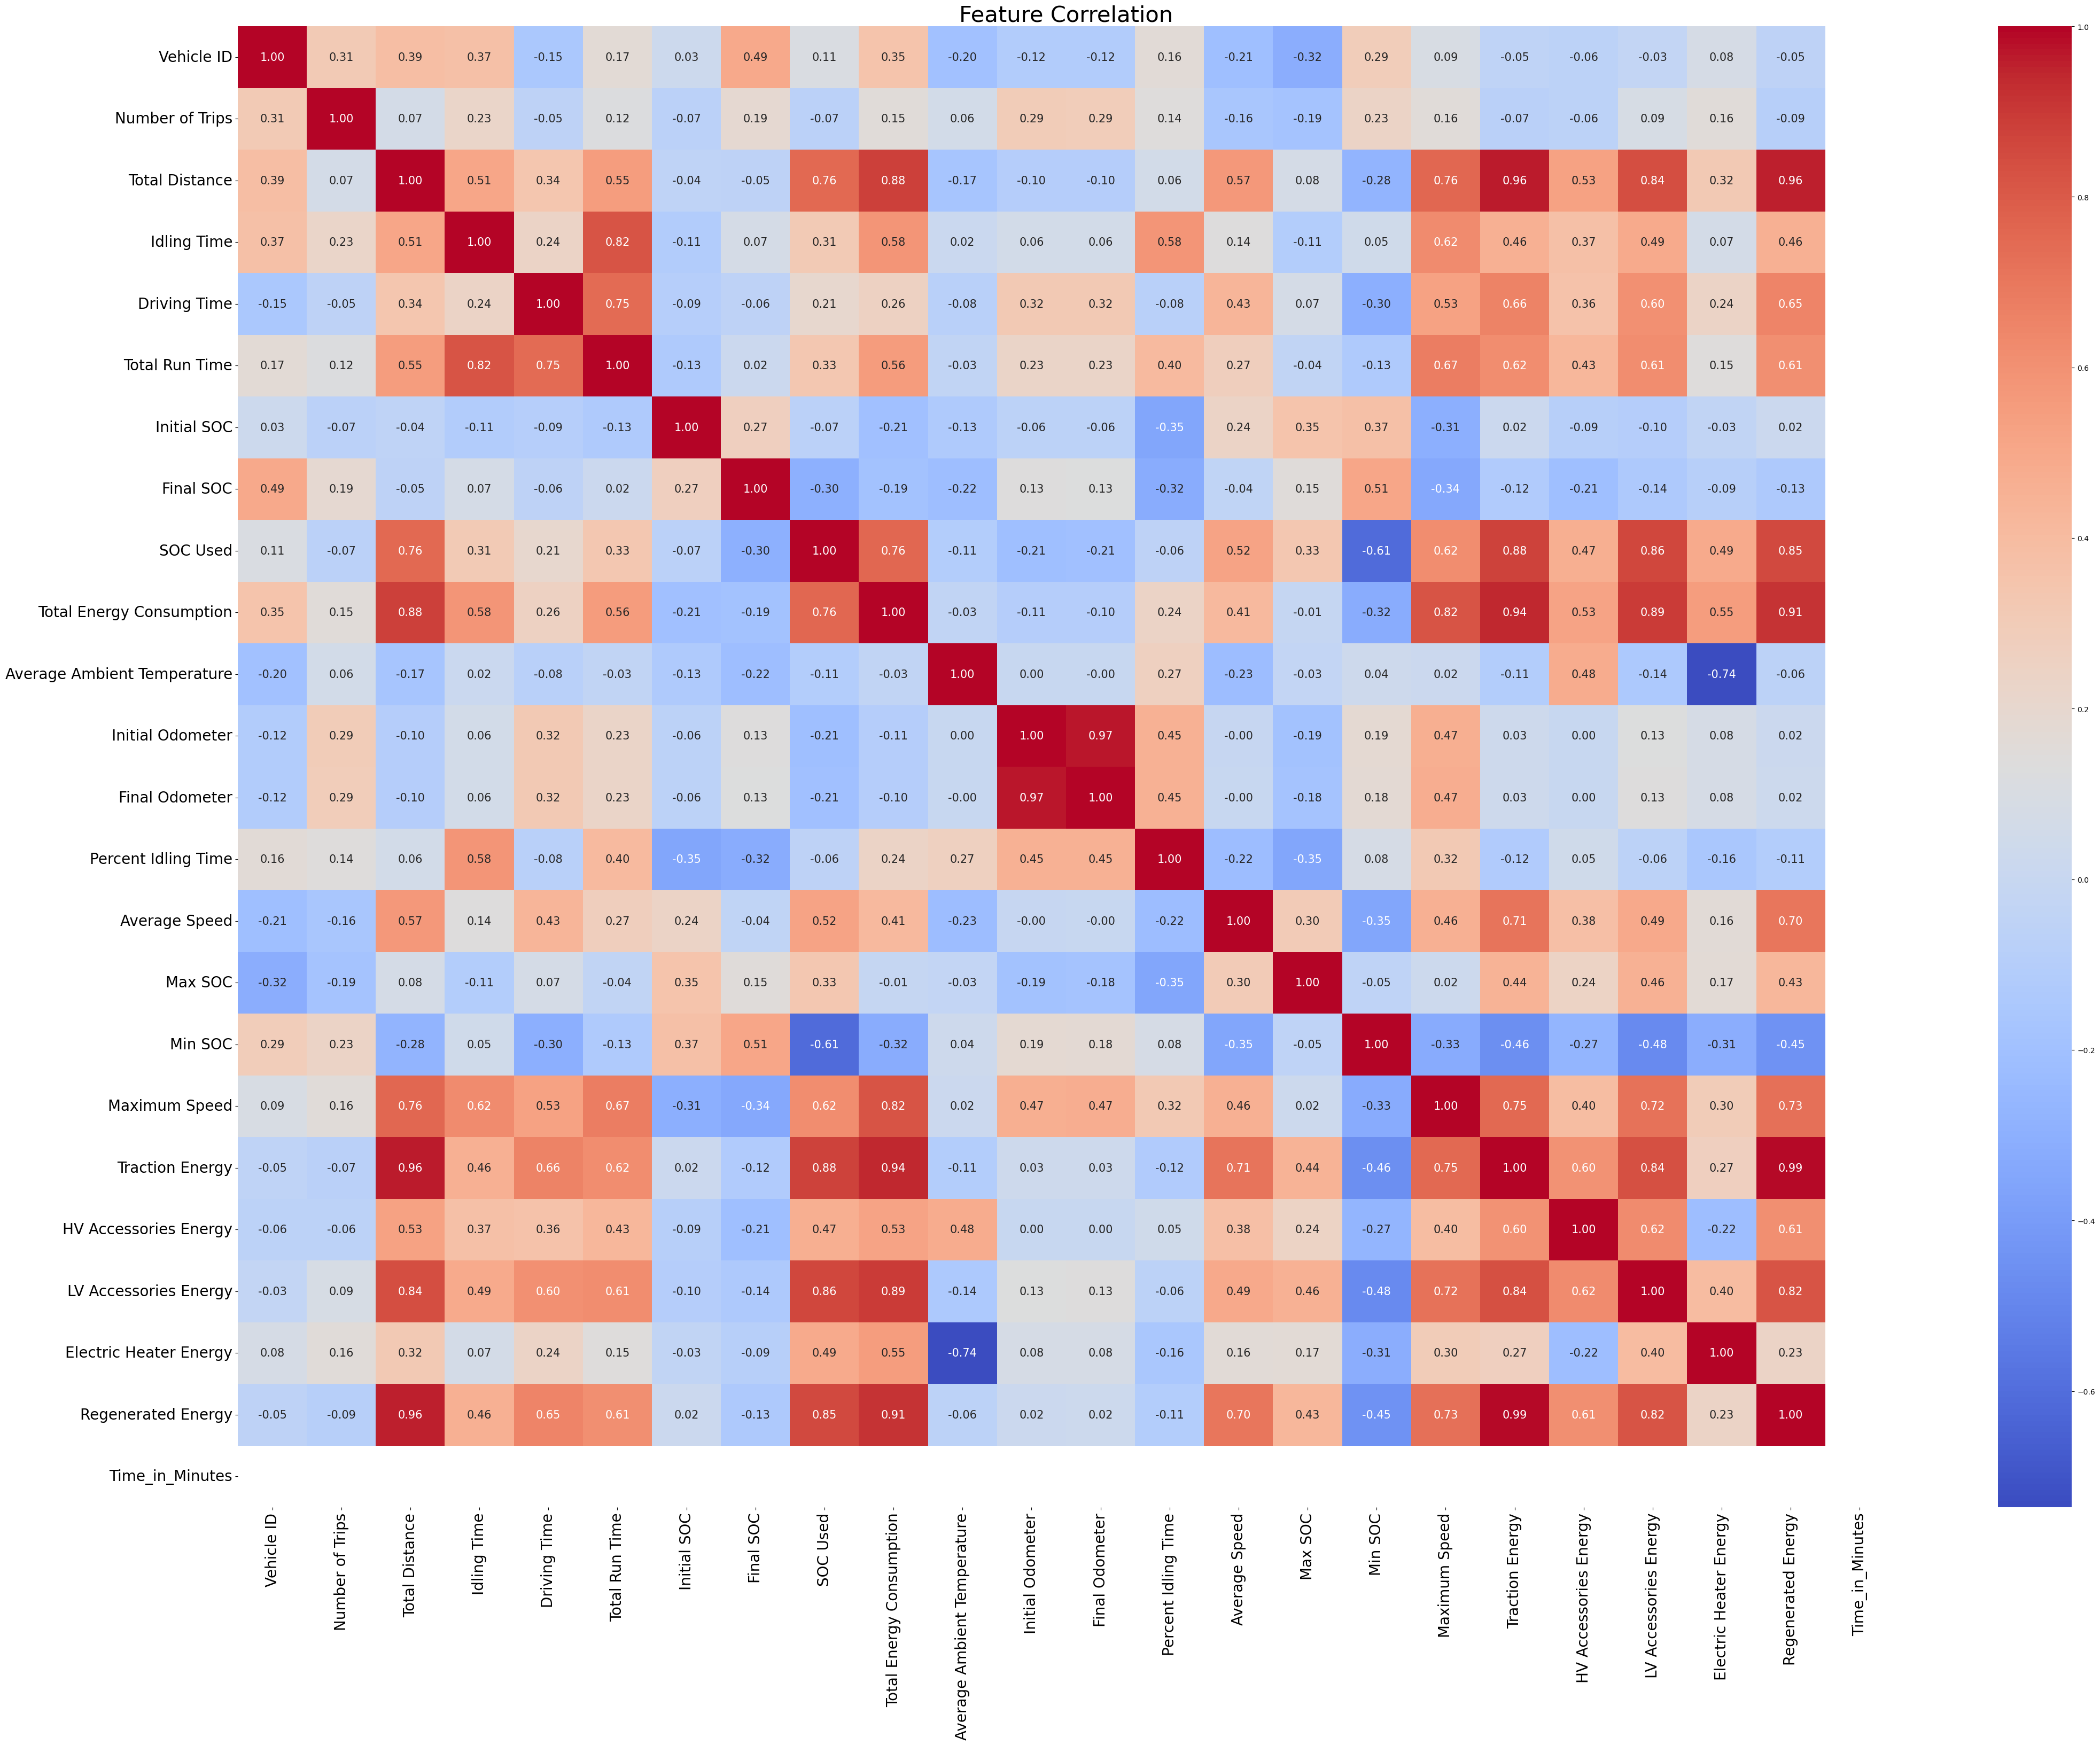

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(50, 36))

# Increase text size for annotations
sns.heatmap(
    dropped_objects_df.corr(),
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    annot_kws={"size": 15}  # Adjust annotation font size
)

# Increase title and axis label font sizes
plt.title('Feature Correlation', fontsize=30)  # Adjust title font size
plt.xticks(fontsize=20)  # Adjust x-axis tick font size
plt.yticks(fontsize=20)  # Adjust y-axis tick font size

plt.show()

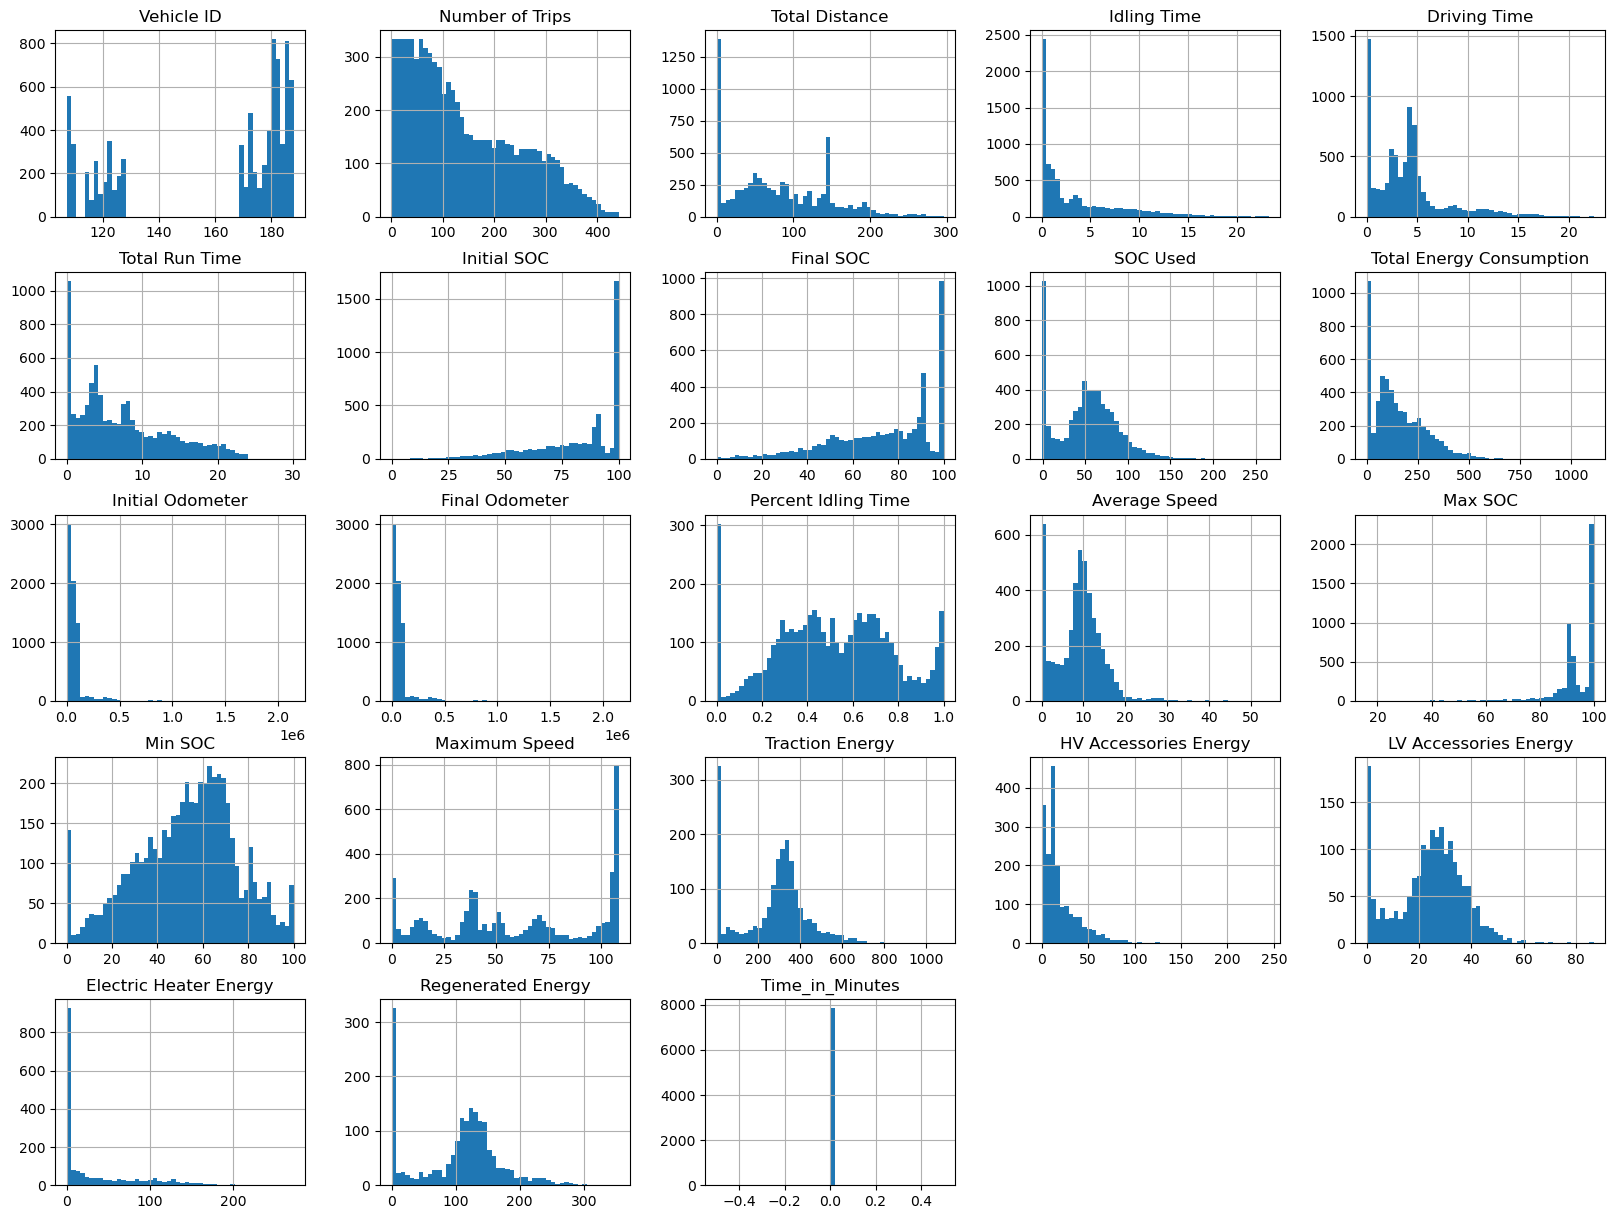

In [23]:
import matplotlib.pyplot as plt
dropped_objects_df.hist(bins=50, figsize=(20,15))
plt.show()

# Machine Learning Models

In [25]:
ml_data = dropped_objects_df.copy()
ml_data.dropna(inplace=True)

## Linear Regression

Mean Squared Error: 774.3303285499637
Mean Absolute Error: 20.89790907684392
R²: 0.8233380012421221


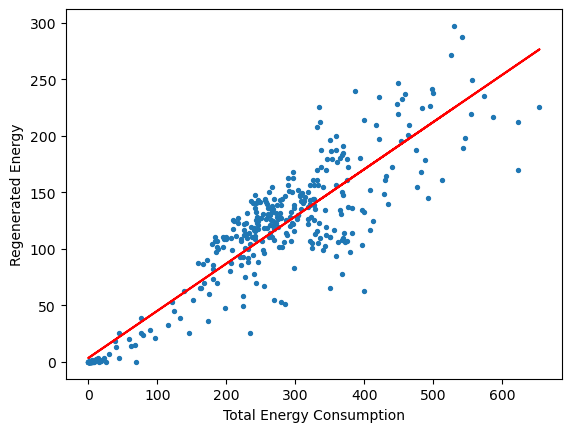

In [27]:
X = pd.DataFrame(ml_data['Total Energy Consumption'])
y = ml_data['Regenerated Energy']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

reg = LinearRegression().fit(X_train, y_train)

y_pred = reg.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

r2 = r2_score(y_test, y_pred)
print("R²:", r2)

plt.scatter(X_test, y_test, s=8)
plt.plot(X_test, y_pred, c='red')
plt.xlabel('Total Energy Consumption')
plt.ylabel('Regenerated Energy')
plt.show()

## Random Forest Regression

Mean Squared Error: 1566.0085416966492
Mean Absolute Error: 23.32718703989704
R²: 0.9266180320739095


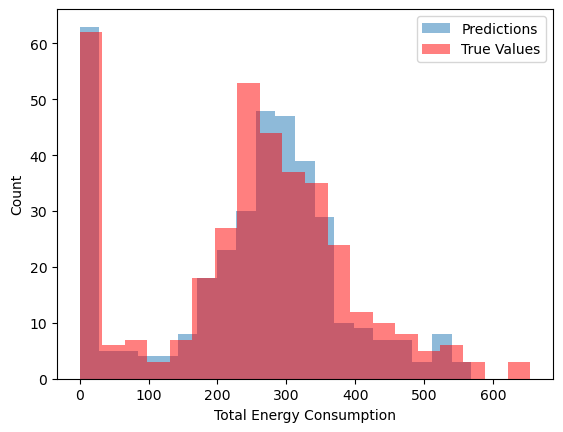

In [29]:
X = ml_data[['Idling Time', 'Driving Time', 'SOC Used', 'Average Speed', 'Total Distance']]
y = ml_data['Total Energy Consumption']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

model = RandomForestRegressor()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

r2 = r2_score(y_test, y_pred)
print("R²:", r2)

plt.hist(y_pred, alpha=0.5, bins=20, label='Predictions')
plt.hist(y_test, color='red', alpha=0.5, bins=20, label='True Values')
plt.xlabel('Total Energy Consumption')
plt.ylabel('Count')
plt.legend()
plt.show()

## Gradient Boosting Regression

Mean Squared Error: 233.19137847154073
Mean Absolute Error: 9.71145569500828
R²: 0.94679782840092


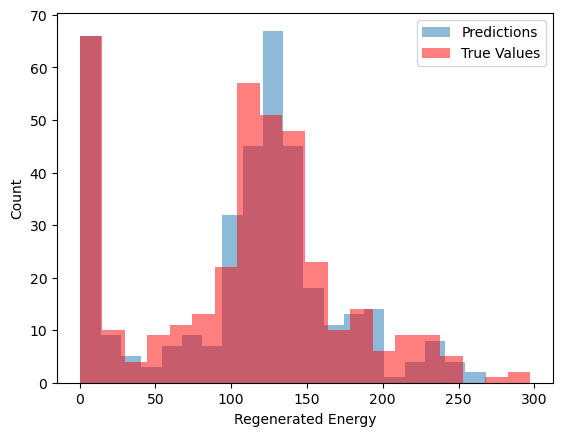

In [31]:
X = ml_data[['Idling Time', 'Driving Time', 'SOC Used', 'Average Speed', 'Total Distance']]
y = ml_data['Regenerated Energy']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

reg = GradientBoostingRegressor()

reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

r2 = r2_score(y_test, y_pred)
print("R²:", r2)

plt.hist(y_pred, alpha=0.5, bins=20, label='Predictions')
plt.hist(y_test, color='red', alpha=0.5, bins=20, label='True Values')
plt.xlabel('Regenerated Energy')
plt.ylabel('Count')
plt.legend()
plt.show()

# Deep Learning Models

## Total Energy Consumption

### FNN Model

In [35]:
#Copying data for model
fnn_model_data = dropped_objects_df.copy()#dropped_low_count_df.copy()

#Removing columns with majority NaN values, and they are all highly correlated with Total Energy Consumption
fnn_model_data = fnn_model_data.drop(columns=['Traction Energy', 'HV Accessories Energy', 'LV Accessories Energy', 'Electric Heater Energy', 'Regenerated Energy'])

#Removing all rows with NaN
fnn_model_data.dropna(inplace=True)

fnn_model_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2253 entries, 65970 to 69639
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Vehicle ID                   2253 non-null   int32  
 1   Number of Trips              2253 non-null   int64  
 2   Total Distance               2253 non-null   float64
 3   Idling Time                  2253 non-null   float64
 4   Driving Time                 2253 non-null   float64
 5   Total Run Time               2253 non-null   float64
 6   Initial SOC                  2253 non-null   float64
 7   Final SOC                    2253 non-null   float64
 8   SOC Used                     2253 non-null   float64
 9   Total Energy Consumption     2253 non-null   float64
 10  Average Ambient Temperature  2253 non-null   object 
 11  Initial Odometer             2253 non-null   float64
 12  Final Odometer               2253 non-null   float64
 13  Percent Idling Tim

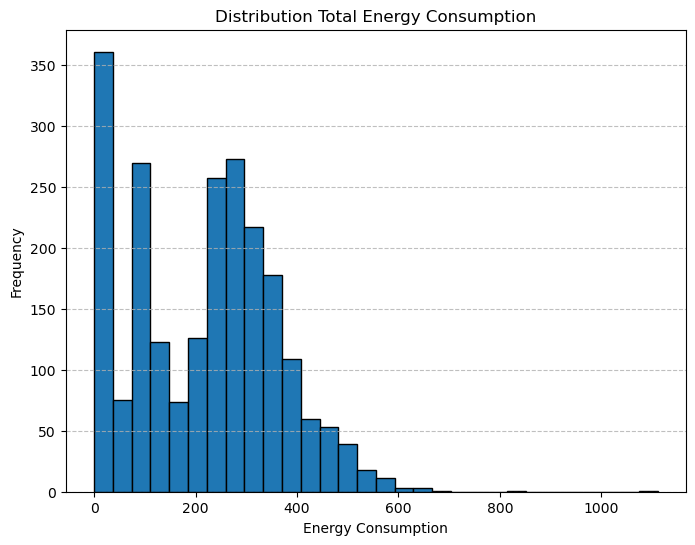

In [36]:
#Will predict Total Energy Consumption
#Taking a look at the values for Charging Duration (hours)

plt.figure(figsize=(8, 6))
plt.hist(fnn_model_data["Total Energy Consumption"], bins=30, edgecolor='black')
plt.title("Distribution Total Energy Consumption")
plt.xlabel("Energy Consumption")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.8)
plt.show()

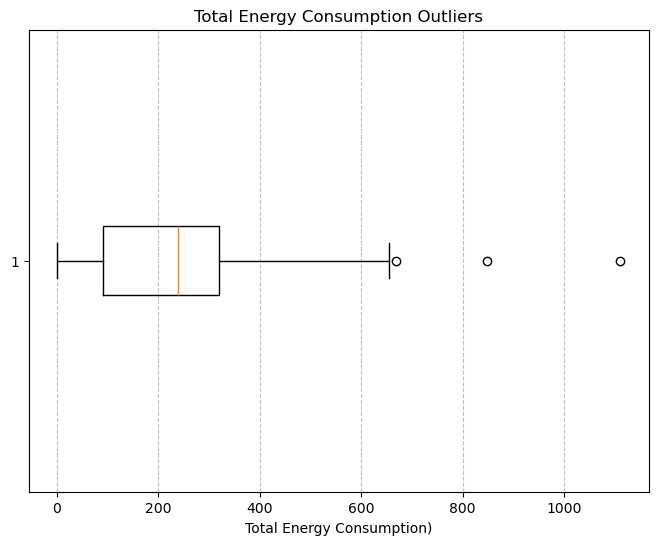

In [37]:
plt.figure(figsize=(8, 6))
plt.boxplot(fnn_model_data["Total Energy Consumption"], vert=False)
plt.title("Total Energy Consumption Outliers")
plt.xlabel("Total Energy Consumption)")
plt.grid(axis='x', linestyle='--', alpha=0.8)
plt.show()

In [38]:
#We can see there are 2257 rows
fnn_model_data.shape

(2253, 19)

In [39]:
#Drop outliers for Total Energy Consumption (Anything 800 or higher)- only 2 rows are dropped
fnn_model_data = fnn_model_data[fnn_model_data["Total Energy Consumption"] < 800]
fnn_model_data.shape

(2251, 19)

In [40]:
#Predictors
X = fnn_model_data.drop(columns=['Total Energy Consumption'])

#Target
y = fnn_model_data['Total Energy Consumption']

#Splitting data
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.20)
#
##Preprocessing
#
scaler = StandardScaler()

#Fit/transform- Changing back to Dataframe as well
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train))
X_test_scaled = pd.DataFrame(scaler.transform(X_test))

In [41]:
#Building FNN model

input_shape = X_train_scaled.shape[1]

model = Sequential([
    Dense(256, activation='relu', input_shape=(input_shape,)),
    BatchNormalization(),
    Dropout(0.5),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(16, activation='relu'),
    Dropout(0.1),

    Dense(1, activation='linear') #Activation layer is a Linear Regression
])

C:\Users\marieo3\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [42]:
#Compiling
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

#Training/fitting the model
history=model.fit(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test), epochs=45, batch_size=32)

#Evaluation using loss and mae
loss, mae = model.evaluate(X_test_scaled, y_test, verbose=1)


Epoch 1/45
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 69151.9922 - mae: 220.5685 - val_loss: 61389.1406 - val_mae: 204.5404
Epoch 2/45
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 64839.5117 - mae: 211.5712 - val_loss: 57991.6523 - val_mae: 199.9309
Epoch 3/45
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 62347.7500 - mae: 206.3496 - val_loss: 48256.3594 - val_mae: 183.9814
Epoch 4/45
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 52577.6875 - mae: 192.3764 - val_loss: 35876.1914 - val_mae: 159.9346
Epoch 5/45
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 41975.8672 - mae: 172.0491 - val_loss: 21462.2773 - val_mae: 122.8019
Epoch 6/45
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 27603.5996 - mae: 139.7866 - val_loss: 11279.9727 - val_mae: 85.8026
Epoch 7/45
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 15755.9697 - mae: 100.7955 - val_loss: 5202.4062 - val_mae: 52.5355
Epoch 8/45
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9369.4277 - mae: 76.9430 - val_loss: 3552.8625 -

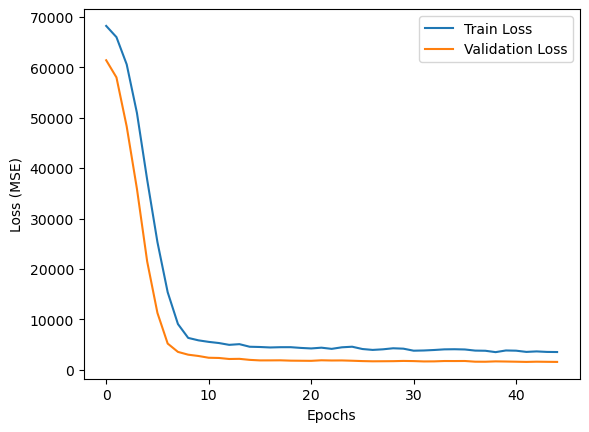

In [43]:
import matplotlib.pyplot as plt

# Plot training & validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


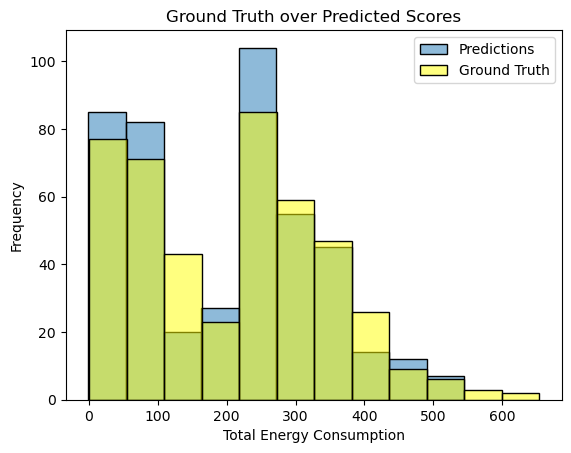

In [44]:
#Creating predictions
y_preds = model.predict(X_test_scaled)

#Ground Truth Score histogram overlayed on Predicted Scores
sns.histplot(y_preds, color='blue', alpha=0.5, kde=False, label='Predictions')
sns.histplot(y_test, color='yellow', alpha=0.5, kde=False, label='Ground Truth')

plt.xlabel('Total Energy Consumption')
plt.ylabel('Frequency')
plt.title('Ground Truth over Predicted Scores')
plt.legend()

plt.show()

As seen by the skewdness to the right, the model tends to slightly overestimate the true values. However, it seems to predict the majority of the values well, and this overestimation isn't shown in the core of the data.

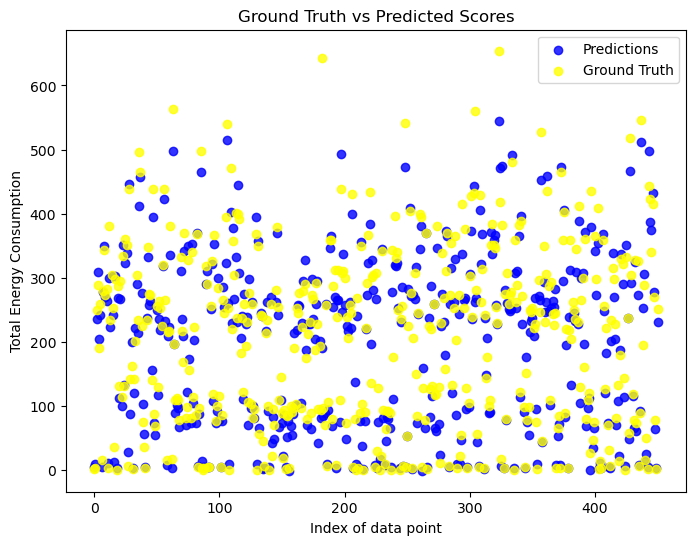

In [46]:
plt.figure(figsize=(8, 6))

#Predictions
plt.scatter(range(len(y_preds)), y_preds, color='blue', alpha=0.8, label='Predictions')

#Ground Truth
plt.scatter(range(len(y_test)), y_test, color='yellow', alpha=0.8, label='Ground Truth')

plt.xlabel('Index of data point')
plt.ylabel('Total Energy Consumption')
plt.title('Ground Truth vs Predicted Scores')
plt.legend()

plt.show()

There is a very good overlap between the predicited values, and the ground truth values as shown by the scatterplot.

In [48]:
import lime
from lime.lime_tabular import LimeTabularExplainer



explainer = LimeTabularExplainer(X_train_scaled.values,  # Convert to NumPy array
                                 mode="regression",
                                 training_labels=y_train,
                                 feature_names=X_train.columns,  # Keep original feature names
                                 discretize_continuous=True)

# Select a sample for explanation
i = 18  # Index of the sample to explain
sample = X_test_scaled.iloc[i].values.reshape(1, -1)  # Single sample as NumPy array
explanation = explainer.explain_instance(sample.flatten(),
                                         model.predict,
                                         num_features=23)
# Show the explanation
table_html=explanation.show_in_notebook()  # Displays the explanation in Jupyter Notebook

# Configure pandas to show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
# Display the HTML
display(table_html)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


None

### FCNN Ramdom search hyperparameter

In [50]:
pip install scikeras

Note: you may need to restart the kernel to use updated packages.


In [51]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


In [52]:
#Drop outliers for Total Energy Consumption (Anything 800 or higher)- only 2 rows are dropped
dropped_objects_df = dropped_objects_df[dropped_objects_df["Total Energy Consumption"] < 800]

In [53]:
#Copying data for model
fcnn_model_data = dropped_objects_df.copy()

#Removing all rows with NaN
fcnn_model_data.dropna(inplace=True)

fcnn_model_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1845 entries, 65970 to 69008
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Vehicle ID                   1845 non-null   int32  
 1   Number of Trips              1845 non-null   int64  
 2   Total Distance               1845 non-null   float64
 3   Idling Time                  1845 non-null   float64
 4   Driving Time                 1845 non-null   float64
 5   Total Run Time               1845 non-null   float64
 6   Initial SOC                  1845 non-null   float64
 7   Final SOC                    1845 non-null   float64
 8   SOC Used                     1845 non-null   float64
 9   Total Energy Consumption     1845 non-null   float64
 10  Average Ambient Temperature  1845 non-null   object 
 11  Initial Odometer             1845 non-null   float64
 12  Final Odometer               1845 non-null   float64
 13  Percent Idling Tim

In [54]:
# X is the feature matrix, y is the target variable for Final Odometer

X = fcnn_model_data.drop(columns=['Total Energy Consumption'])
y = fcnn_model_data['Total Energy Consumption']

# First, split into train + validation and test
X_temp, X_test_fcnn, y_temp, y_test_fcnn = train_test_split(X, y, test_size=0.2, random_state=42)

# Then split train + validation into train and validation
X_train_fcnn, X_val_fcnn, y_train_fcnn, y_val_fcnn = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)
# 0.25 x 0.8 = 0.2 (20% of the total data for validation)

print(f"Training set: {len(X_train_fcnn)} samples")
print(f"Validation set: {len(X_val_fcnn)} samples")
print(f"Test set: {len(X_test_fcnn)} samples")

# Standardize the data (scaling helps FCNNs converge faster)
scaler = StandardScaler()

#Fit/transform- Changing back to Dataframe as well
X_train_fcnn = scaler.fit_transform(X_train_fcnn)
X_test_fcnn = scaler.transform(X_test_fcnn)
X_val_fcnn = scaler.transform(X_val_fcnn)




Training set: 1107 samples
Validation set: 369 samples
Test set: 369 samples


In [55]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Nadam

def build_model(optimizer='adam', learning_rate=0.001, neurons=64, dropout_rate=0.3, **kwargs):
    model = Sequential()

    # Input and first hidden layer
    model.add(Dense(neurons, activation='relu', input_shape=(X_train_fcnn.shape[1],)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))

    # Second hidden layer
    model.add(Dense(int(neurons / 2), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(max(dropout_rate - 0.1, 0.2)))  # Ensuring dropout rate doesn't go below 0.2

    # Third hidden layer
    model.add(Dense(int(neurons / 4), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(max(dropout_rate - 0.2, 0.2)))

    # Fourth hidden layer
    model.add(Dense(int(neurons / 8), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(max(dropout_rate - 0.3, 0.2)))

    # Output layer
    model.add(Dense(1, activation='linear'))  # 'linear' for regression

    # Optimizer initialization
    if optimizer == 'adam':
        optimizer_instance = Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        optimizer_instance = SGD(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        optimizer_instance = RMSprop(learning_rate=learning_rate)
    elif optimizer == 'nadam':
        optimizer_instance = Nadam(learning_rate=learning_rate)
    else:
        raise ValueError("Optimizer not recognized. Use 'adam', 'sgd', 'rmsprop', or 'nadam'.")
    
    model.compile(optimizer=optimizer_instance, loss='mse', metrics=['mae'])

    return model


In [56]:
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.optimizers import SGD, RMSprop, Adam,  Nadam

# Wrap the model with KerasRegressor and specify custom parameters
model = KerasRegressor(model=build_model, verbose=0)

# Define the hyperparameter grid
param_grid = {
    'model__optimizer': ['adam', 'sgd', 'rmsprop', 'nadam'],
    'model__learning_rate': [0.001, 0.0005, 0.0001],
    'model__neurons': [32, 64, 128,256],
    'model__dropout_rate': [0.2, 0.3, 0.4,0.5,0.6],
    'fit__epochs': [10,20,50, 100],
    'fit__batch_size': [16, 32, 64,128]
}

In [57]:
# Set up random search with 3-fold cross-validation
random_search = RandomizedSearchCV(estimator=model,
                                   param_distributions=param_grid,
                                   n_iter=20,  # Number of random combinations to try
                                   cv=3,
                                   verbose=1,
                                   n_jobs=-1)  # Use all available cores
# Run the random search
random_search_result = random_search.fit(X_train_fcnn, y_train_fcnn)

# Display best hyperparameters and score
print("Best Hyperparameters:", random_search_result.best_params_)
print("Best Score:", random_search_result.best_score_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


C:\Users\marieo3\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Best Hyperparameters: {'model__optimizer': 'sgd', 'model__neurons': 128, 'model__learning_rate': 0.0001, 'model__dropout_rate': 0.2, 'fit__epochs': 100, 'fit__batch_size': 32}
Best Score: 0.9864422014926074


### FCNN

In [59]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler


In [60]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop  # Import the optimizers

# Extract the best hyperparameters
best_params = random_search_result.best_params_
optimizer_str = best_params['model__optimizer']
learning_rate = float(best_params['model__learning_rate'])  # Convert to float
neurons = int(best_params['model__neurons'])  # Convert to int
dropout_rate = float(best_params['model__dropout_rate'])  # Convert to float
epochs = int(best_params['fit__epochs'])  # Convert to int
batch_size = int(best_params['fit__batch_size'])  # Convert to int

# Ensure dropout_rate is not below 0.2
dropout_rate = max(0.2, dropout_rate)

# Map string optimizer to actual optimizer class
optimizer_dict = {
    'adam': Adam,
    'sgd': SGD,
    'rmsprop': RMSprop,
    'nadam': Nadam
}

# Initialize the model
model = Sequential()

# Input and first hidden layer
model.add(Dense(neurons, activation='relu', input_shape=(X_train_fcnn.shape[1],)))
model.add(BatchNormalization())
model.add(Dropout(dropout_rate))

# Second hidden layer
model.add(Dense(int(neurons / 2), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(max(0.2, dropout_rate - 0.1)))  # Ensure rate is >= 0.2

# Third hidden layer
model.add(Dense(int(neurons / 4), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(max(0.2, dropout_rate - 0.2)))  # Ensure rate is >= 0.2

# Fourth hidden layer
model.add(Dense(int(neurons / 8), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(max(0.2, dropout_rate - 0.3)))  # Ensure rate is >= 0.2

# Output layer
model.add(Dense(1, activation='linear'))

# Compile the model with the dynamically selected optimizer and learning rate
optimizer_instance = optimizer_dict[optimizer_str](learning_rate=learning_rate)
model.compile(optimizer=optimizer_instance, loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train_fcnn, y_train_fcnn,
                    epochs=epochs,  # Correct variable name
                    batch_size=batch_size,  # Correct variable name
                    validation_data=(X_test_fcnn, y_test_fcnn),
                    verbose=1)

# Evaluation using loss and mae
loss, mae = model.evaluate(X_test_fcnn, y_test_fcnn, verbose=1)


Epoch 1/100


C:\Users\marieo3\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 74687.8125 - mae: 232.5404 - val_loss: 52076.1250 - val_mae: 199.3917
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 35420.6641 - mae: 155.0619 - val_loss: 24405.7188 - val_mae: 122.3885
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4122.1367 - mae: 48.6063 - val_loss: 23399.4062 - val_mae: 123.6134
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3582.5161 - mae: 45.1974 - val_loss: 7979.5181 - val_mae: 73.8810
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3518.5400 - mae: 45.0835 - val_loss: 7004.9341 - val_mae: 67.2165
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2581.8259 - mae: 39.8466 - val_loss: 4588.3315 - val_mae: 53.8445
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3418.9375 - mae: 44.2281 - val_loss: 1313.9574 - val_mae: 32.0708
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2862.5161 - mae: 41.3167 - val_loss: 1240.5244 - val_mae: 27.9532
E

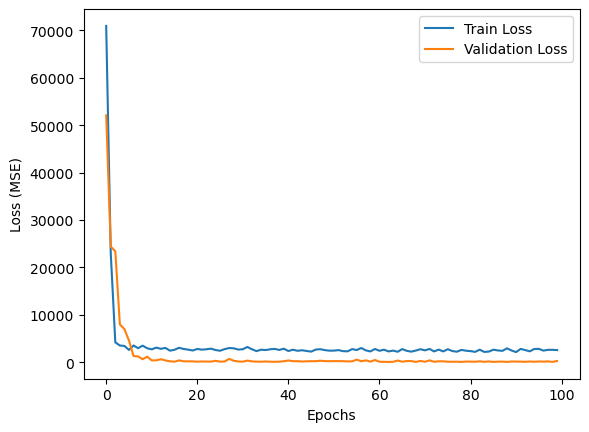

In [61]:
import matplotlib.pyplot as plt

# Plot training & validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


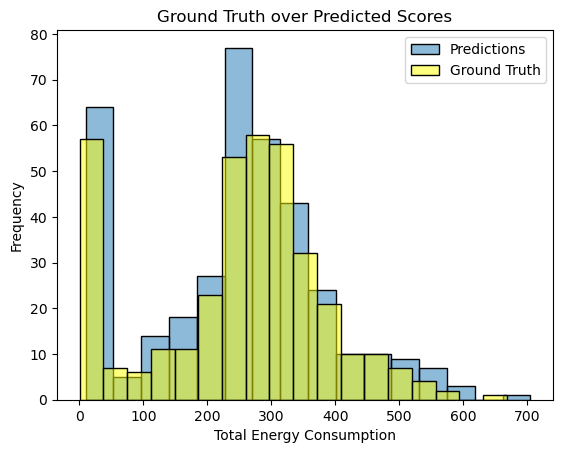

In [62]:
#Creating predictions
y_preds_fcnn = model.predict(X_test_fcnn)

#Ground Truth Score histogram overlayed on Predicted Scores
sns.histplot(y_preds_fcnn, color='blue', alpha=0.5, kde=False, label='Predictions')
sns.histplot(y_test_fcnn, color='yellow', alpha=0.5, kde=False, label='Ground Truth')

plt.xlabel('Total Energy Consumption')
plt.ylabel('Frequency')
plt.title('Ground Truth over Predicted Scores')
plt.legend()

plt.show()

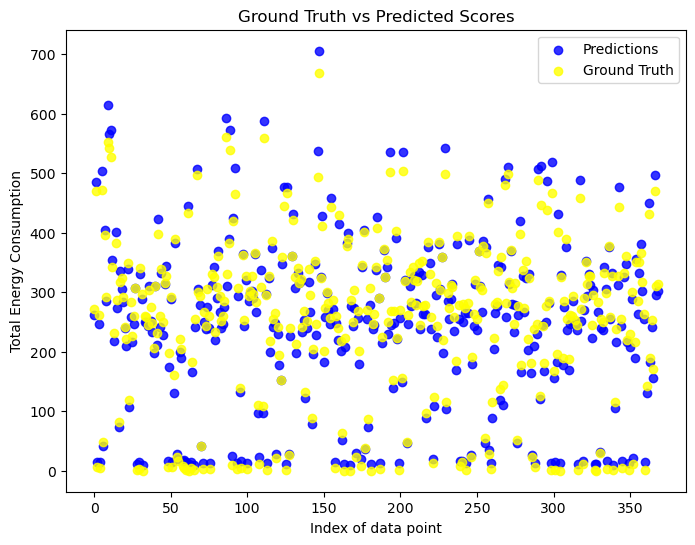

In [63]:
plt.figure(figsize=(8, 6))

#Predictions
plt.scatter(range(len(y_preds_fcnn)), y_preds_fcnn, color='blue', alpha=0.8, label='Predictions')

#Ground Truth
plt.scatter(range(len(y_test_fcnn)), y_test_fcnn, color='yellow', alpha=0.8, label='Ground Truth')

plt.xlabel('Index of data point')
plt.ylabel('Total Energy Consumption')
plt.title('Ground Truth vs Predicted Scores')
plt.legend()

plt.show()

In [64]:
#pip install lime shap

In [65]:
import lime
from lime.lime_tabular import LimeTabularExplainer

# Initialize the explainer
explainer = LimeTabularExplainer(X_train_fcnn,
                                 mode="regression",
                                 training_labels=y_train_fcnn,
                                 feature_names=fcnn_model_data.drop(columns=['Total Energy Consumption']).columns,  # Replace 'target' as appropriate
                                 discretize_continuous=True)

# Select a sample for explanation

# Select a sample for explanation
i = 1  # Index of the sample to explain
sample = X_test_fcnn[i].reshape(1, -1) # Single sample as NumPy array

# Generate the explanation
explanation = explainer.explain_instance(sample.flatten(),
                                         model.predict,  # Pass the prediction function
                                         num_features=23)  # Number of features to include in explanation

# Show the explanation
table_html=explanation.show_in_notebook()  # Displays the explanation in Jupyter Notebook

# Configure pandas to show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
# Display the HTML
display(table_html)




157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


None

In [66]:
# Assuming `model` is your trained FCNN
y_pred_fcnn = model.predict(X_test_fcnn)  # Predict on test data
y_pred_classes_fcnn = np.argmax(y_pred_fcnn, axis=1)  # Convert probabilities to class indices


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [67]:
# For regression problems
correction_table = pd.DataFrame({
    'True Value': y_test_fcnn,
    'Predicted Value': y_pred_fcnn.flatten(),
    'Error': np.abs(y_test_fcnn - y_pred_fcnn.flatten())
})

print(correction_table.sort_values(by='Error', ascending=False).head(1000))  # Show top 10 errors


       True Value  Predicted Value      Error
68343      446.15       511.312378  65.162378
68065      552.20       613.935486  61.735486
66509      466.05       519.135315  53.085315
66529      438.60       486.017365  47.417365
66922      526.30       573.030273  46.730273
66507      497.80       541.707703  43.907703
68086      494.00       536.825195  42.825195
68089      465.30       508.091827  42.791827
66219      304.25       265.941315  38.308685
68941      668.55       705.510681  36.960681
66621      314.80       277.962433  36.837567
67318      442.50       477.371857  34.871857
68069      501.75       535.540466  33.790466
68966      559.80       593.211243  33.411243
66516      471.20       504.019196  32.819196
66848      144.00       111.389206  32.610794
67709      539.55       571.573059  32.023059
68049      445.50       477.454926  31.954926
66056      504.15       535.871826  31.721826
66260      303.80       272.742950  31.057050
68062      401.45       432.000244

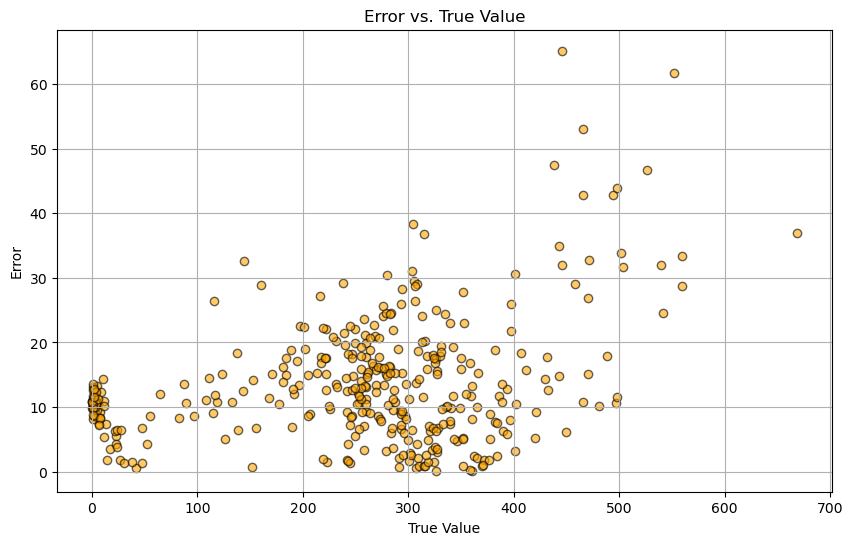

In [68]:
plt.figure(figsize=(10, 6))
plt.scatter(correction_table['True Value'], correction_table['Error'], alpha=0.6, color='orange', edgecolors='k')
plt.xlabel('True Value')
plt.ylabel('Error')
plt.title('Error vs. True Value')
plt.grid(True)
plt.show()

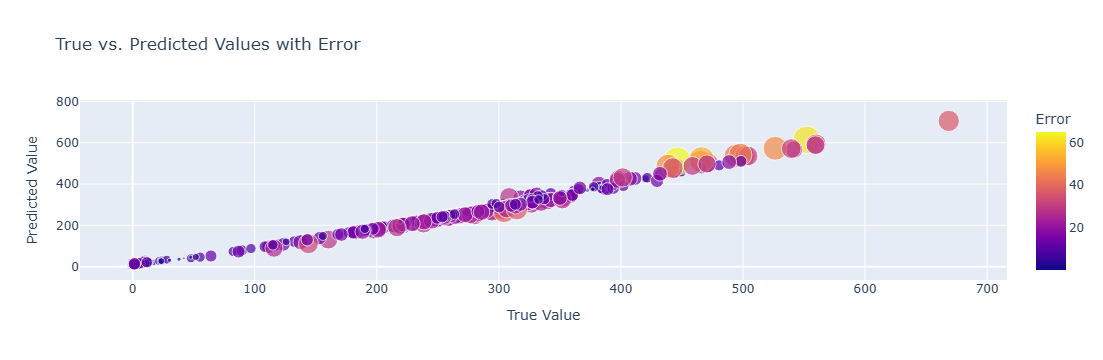

In [69]:
import plotly.express as px

# Interactive scatter plot
fig = px.scatter(correction_table, x='True Value', y='Predicted Value', 
                 size='Error', color='Error', 
                 title='True vs. Predicted Values with Error',
                 labels={'True Value': 'True Value', 'Predicted Value': 'Predicted Value'})
fig.show()